IMPORT MODULES

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

---

In [4]:
test_features = pd.read_csv('kc_house_data_test_features.csv', index_col=0)

In [5]:
training_data = pd.read_csv('kc_house_data_train.csv', index_col=0)

In [6]:
categorical = ['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']
continuous = ['sqft_living', 'bedrooms', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
price = training_data['price']

In [146]:
#numbers to measure against when getting RMSE or MSE

print('price min:', price.min())
print('price max:', price.max())
print('price mean:', price.mean())
print('price median:', price.median())

price min: 75000.0
price max: 7700000.0
price mean: 540739.5486408329
price median: 450000.0


In [7]:
cont_data = training_data[continuous]
cat_data = training_data[categorical]

---

In [8]:
cont_data.corr() 

,price,sqft_living,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
price,1.000000,0.703540,0.305106,0.524335,0.086803,0.607760,0.323312,0.585567,0.081423
sqft_living,0.703540,1.000000,0.570428,0.755270,0.166810,0.876696,0.435529,0.755066,0.179570
bedrooms,0.305106,0.570428,1.000000,0.507867,0.029375,0.472492,0.300085,0.387589,0.026665
bathrooms,0.524335,0.755270,0.507867,1.000000,0.085470,0.686853,0.282700,0.568080,0.086499
sqft_lot,0.086803,0.166810,0.029375,0.085470,1.000000,0.180755,0.008065,0.136959,0.701875
sqft_above,0.607760,0.876696,0.472492,0.686853,0.180755,1.000000,-0.051199,0.731077,0.193874
sqft_basement,0.323312,0.435529,0.300085,0.282700,0.008065,-0.051199,1.000000,0.199521,0.010007
sqft_living15,0.585567,0.755066,0.387589,0.568080,0.136959,0.731077,0.199521,1.000000,0.178533
sqft_lot15,0.081423,0.179570,0.026665,0.086499,0.701875,0.193874,0.010007,0.178533,1.000000


In [9]:
cat_data.corr() 

,floors,waterfront,view,condition,grade,zipcode
floors,1.000000,0.025132,0.025883,-0.259230,0.458984,-0.060560
waterfront,0.025132,1.000000,0.407565,0.009608,0.092234,0.034282
view,0.025883,0.407565,1.000000,0.045060,0.249554,0.089475
condition,-0.259230,0.009608,0.045060,1.000000,-0.142066,0.007068
grade,0.458984,0.092234,0.249554,-0.142066,1.000000,-0.184946
zipcode,-0.060560,0.034282,0.089475,0.007068,-0.184946,1.000000


In [10]:
#choosing 3 cont variables + 3 categorical vars
features = ['sqft_living', 'bedrooms', 'bathrooms', 'grade', 'waterfront', 'view']

In [150]:
#feature engineering

#if a house has 1 or more views, it's a 1 otherwise a 0
training_data['view_bin'] = np.where(training_data['view'].values >= 1, 1,0)
training_data['bedrooms'] = np.where((training_data.bedrooms > 6),6,training_data['bedrooms'])

In [153]:
# Continuous features to scale 
#living = training_data['sqft_living']
logliving = np.log(training_data['sqft_living'])
bed = training_data['bedrooms']
bath = training_data['bathrooms']

In [154]:
# Scale the features
scaler = StandardScaler()
#scaled_living = scaler.fit_transform(training_data[['sqft_living']])
scaled_livinglog = scaler.fit_transform(np.log(training_data[['sqft_living']]))
scaled_bed = scaler.fit_transform(training_data[['bedrooms']])
scaled_bath = scaler.fit_transform(training_data[['bathrooms']])

In [155]:
# Create a dataframe with scaled features
data_fin = pd.DataFrame([])
data_fin['living'] = scaled_livinglog.flatten()
data_fin['bed'] = scaled_bed.flatten()
data_fin['bath'] = scaled_bath.flatten()

In [156]:
# Create dummies for categorical features
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
water = training_data['waterfront']
view = training_data['view_bin']

In [157]:
#drop the grade dummies with high p-values
grade_dummies.drop(columns=['grade_3','grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8'], inplace=True)

In [158]:
#separate the result
price = training_data['price']

In [159]:
# Concat with dataframe 
data_fin = pd.concat([price, data_fin, grade_dummies, water, view], axis=1)

In [140]:
#data_fin

In [160]:
# Create model
outcome = 'price'
predictors = data_fin.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=data_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     2717.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        14:59:26   Log-Likelihood:            -2.3820e+05
No. Observations:               17290   AIC:                         4.764e+05
Df Residuals:                   17279   BIC:                         4.765e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.572e+05   2151.478    212.517      0.000    4.53e+05    4.61e+05
living      1.058e+05   3363.617     31.447      0.000    9.92e+04    1.12e+05
bed        -7684.9691   2361.431     -3.254      0.001   -1.23e+04   -3056.326
bath        2.283e+04   2770.988      8.240      0.000    1.74e+04    2.83e+04
grade_9     1.739e+05   6113.809     28.441      0.000    1.62e+05    1.86e+05
grade_10     3.89e+05   8979.888     43.315      0.000    3.71e+05    4.07e+05
grade_11    7.144e+05   1.43e+04     50.037      0.000    6.86e+05    7.42e+05
grade_12    1.358e+06   2.85e+04     47.587      0.000     1.3e+06    1.41e+06
grade_13    3.021e+06   7.09e+04     42.583      0.000    2.88e+06    3.16e+06
waterfront  6.585e+05   2.08e+04     31.673      0.000    6.18e+05    6.99e+05
view_bin     1.64e+05   6350.072     25.824      0.000    1.52e+05    1.76e+05
==============================================================================
Omnibus:                    10701.995   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           420026.418
Skew:                           2.390   Prob(JB):                         0.00
Kurtosis:                      26.668   Cond. No.                         60.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
# Test models

# Get a subset of the features and set to x and y

y = data_fin[['price']]
X = data_fin.drop(['price'], axis=1)

#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

# Pickle

Train Mean Squarred Error: price    5.500512e+10
dtype: float64
Test Mean Squarred Error: price    5.095957e+10
dtype: float64


In [162]:
## training the model with lasso

lasso = Lasso(alpha=0.01, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 155844.5868865144
Testing Error: 225742.22061875556


In [163]:
#the difference between maximum and minimum: NRMSE=RMSEymax−ymin
print(train_rmse/(max(price)-min(price)))
print(test_rmse/(max(price)-min(price)))

0.02043863434577238
0.029605537130328596


In [166]:
#the mean: NRMSE=RMSE¯
print(train_rmse/price.mean())
print(test_rmse/price.mean())

0.288206378242973
0.41746941052520803


In [168]:
y_train

,price
2498,429900.0
10932,285000.0
15638,295000.0
15099,275000.0
15560,590000.0
...,...
11284,469000.0
11964,450000.0
5390,295000.0
860,459000.0


In [169]:
y_train_pred

array([527371.72972811, 464392.93088471, 191256.27742258, ...,
       414039.10575648, 479834.10157071, 534350.27414448])

In [170]:
429900.0-527371.72972811

-97471.72972811002

In [171]:
285000.0 - 464392.93088471

-179392.93088471

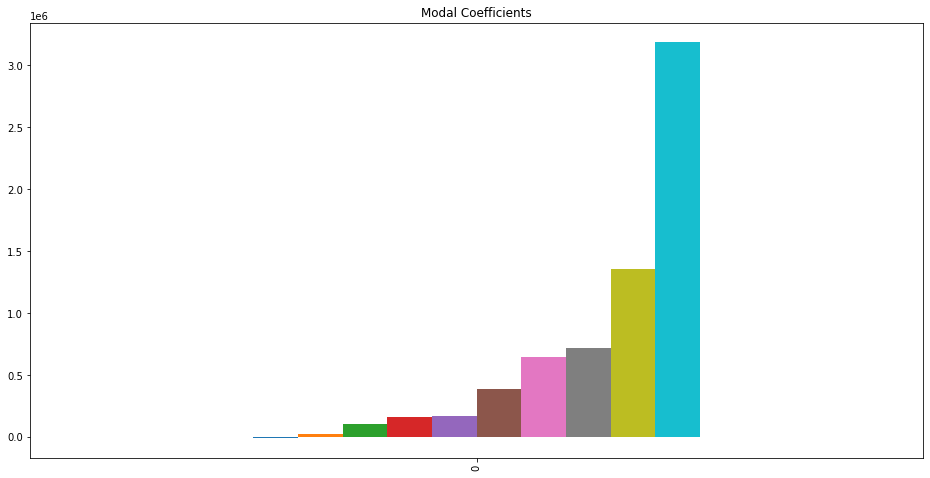

In [164]:
#displaying coefficients with lasso model

lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [165]:
# checking for any coefficients that converge to 0

lasso_coef01.T

,0
bed,-6.643902e+03
bath,2.348294e+04
living,1.061269e+05
view_bin,1.645610e+05
grade_9,1.673402e+05
grade_10,3.877160e+05
waterfront,6.466622e+05
grade_11,7.140027e+05
grade_12,1.358670e+06
grade_13,3.182583e+06
